In [239]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [277]:
def get_batches(arr, arrY, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    # total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    arrY = arrY[:n_batches * batch_size_total]
    
    # Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    arrY = arrY.reshape((batch_size, -1))
    
    # iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]

        y = arrY[:, n:n+seq_length]
        yield x, y

In [278]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [279]:
train_on_gpu = False

In [280]:
class CharRNN(nn.Module):
    
    def __init__(self, inputData, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
#         self.chars = tokens
#         self.int2char = dict(enumerate(self.chars))
#         self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        
        print("Input data shape", len(inputData[0]))
        
        self.lstm = nn.LSTM(len(inputData[0]), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(inputData[0]))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

In [355]:
def train(net, dataX,dataY, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # create training and validation data
    val_idx = int(len(dataX)*(1-val_frac))
    data, val_data = dataX[:val_idx], dataX[val_idx:]
    dataY, val_Y = dataY[:val_idx], dataY[val_idx:]
    
    
#     print("val data size : ", val_data.shape)
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    dataSize = len(data[0]) # single data shape
#     n_char
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
#         print("Data X shape", data.shape)
#         print("Data Y shape", dataY.shape)
        
        
        for x, y in get_batches(data,dataY, batch_size, seq_length):
            counter += 1
            
            x = np.expand_dims(x, axis=2)
#             y = np.expand_dims(y, axis=2)
            
            
            

            
            y= np.reshape(y,(batch_size*seq_length,1)).astype(np.float32)
            
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            
    
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()
            
            
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            

            output, h = net(inputs, h)

            np.set_printoptions(suppress=True)

            numpyOutput = output.detach().numpy()
            numpyTarget =  targets.detach().numpy()

            
    
    
            loss = criterion(output, targets)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, val_Y, batch_size, seq_length):

                    x = np.expand_dims(x, axis=2)

                    y= np.reshape(y,(batch_size*seq_length,1)).astype(np.float32)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    

                    val_h = tuple([each.data for each in val_h])
                    
                    
                    
                    inputs, targets = x, y
                    
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets)
                    print("Loss : ", val_loss.item())
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterationg through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [356]:
n_hidden=512
n_layers=3

# Data Loader

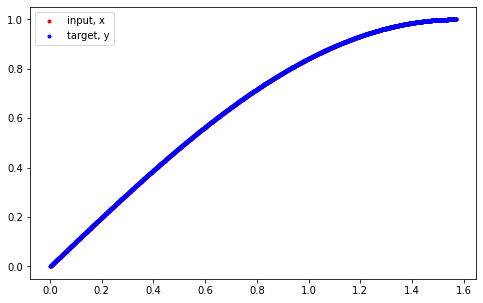

In [425]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 1000

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi/2, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y
# plt.plot(time_steps[1:], data[:], 'b.', label='original, y')

x = np.float32(x)
plt.legend(loc='best')
plt.show()

In [426]:
dataX = x
dataX.shape

dataY = y


In [427]:
type(dataX[0][0])

numpy.float32

# Model Call and Training

In [428]:
net = CharRNN(dataX, n_hidden, n_layers)
print(net)

Input data shape 1
CharRNN(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)


In [429]:
batch_size = 16
seq_length = 5
n_epochs = 20 # start smaller if you are just testing initial behavior

# train the model
train(net, dataX,dataY, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

Loss :  0.5532101392745972
Epoch: 1/20... Step: 10... Loss: 0.1679... Val Loss: 0.5532
Loss :  0.4502831995487213
Epoch: 2/20... Step: 20... Loss: 0.0886... Val Loss: 0.4503
Loss :  0.4919227659702301
Epoch: 3/20... Step: 30... Loss: 0.0395... Val Loss: 0.4919
Loss :  0.30859747529029846
Epoch: 4/20... Step: 40... Loss: 0.0647... Val Loss: 0.3086
Loss :  0.2939322888851166
Epoch: 5/20... Step: 50... Loss: 0.0306... Val Loss: 0.2939
Loss :  0.21916517615318298
Epoch: 6/20... Step: 60... Loss: 0.0163... Val Loss: 0.2192
Loss :  0.24403426051139832
Epoch: 7/20... Step: 70... Loss: 0.0085... Val Loss: 0.2440
Loss :  0.1566176414489746
Epoch: 8/20... Step: 80... Loss: 0.0054... Val Loss: 0.1566
Loss :  0.22324085235595703
Epoch: 9/20... Step: 90... Loss: 0.0318... Val Loss: 0.2232
Loss :  0.13845029473304749
Epoch: 10/20... Step: 100... Loss: 0.0488... Val Loss: 0.1385
Loss :  0.15260443091392517
Epoch: 10/20... Step: 110... Loss: 0.0071... Val Loss: 0.1526
Loss :  0.16438640654087067
Epoch

In [430]:
model_name = 'lstm_motion_predict'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

In [431]:
def predict(net, hidden, inputX, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        x = inputX
        
        x = x.reshape((1,1,1))
        print("Input Data ", x)
        
        
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        h = tuple([each.data for each in hidden])
        out, h = net(inputs, h)
        return out,h

In [432]:
dataTest = [0.5]
dataTest = np.asarray(dataTest,dtype=np.float32)
net.eval()
h = net.init_hidden(1)
out,h= predict(net,h,dataTest)
print(out)

Input Data  [[[0.5]]]
tensor([[0.4602]], grad_fn=<AddmmBackward>)


In [437]:
result = []
startVal = 0
for i in range(1000):
    dataTest = []
    dataTest.append(startVal)
    dataTest = np.asarray(dataTest,dtype=np.float32)
    
    out,h = predict(net,h,dataTest)
    
    res = out.detach().numpy()
    result.append(res[0][0])
    startVal = res[0][0]
    

Input Data  [[[0.]]]
Input Data  [[[0.02690065]]]
Input Data  [[[-0.00399707]]]
Input Data  [[[-0.00522598]]]
Input Data  [[[0.00651087]]]
Input Data  [[[0.02381461]]]
Input Data  [[[0.04454361]]]
Input Data  [[[0.06692198]]]
Input Data  [[[0.08891285]]]
Input Data  [[[0.10891905]]]
Input Data  [[[0.12604406]]]
Input Data  [[[0.13996187]]]
Input Data  [[[0.15072258]]]
Input Data  [[[0.1585992]]]
Input Data  [[[0.16397788]]]
Input Data  [[[0.16728222]]]
Input Data  [[[0.16892642]]]
Input Data  [[[0.16928904]]]
Input Data  [[[0.16870117]]]
Input Data  [[[0.167443]]]
Input Data  [[[0.1657455]]]
Input Data  [[[0.16379455]]]
Input Data  [[[0.16173625]]]
Input Data  [[[0.15968229]]]
Input Data  [[[0.15771507]]]
Input Data  [[[0.15589245]]]
Input Data  [[[0.15425195]]]
Input Data  [[[0.15281448]]]
Input Data  [[[0.1515877]]]
Input Data  [[[0.15056883]]]
Input Data  [[[0.14974754]]]
Input Data  [[[0.14910787]]]
Input Data  [[[0.1486304]]]
Input Data  [[[0.14829376]]]
Input Data  [[[0.14807612]

Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[

Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[[0.14897914]]]
Input Data  [[

In [438]:
result = np.asarray(result)


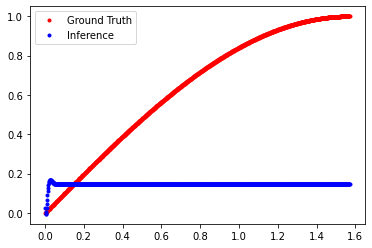

In [439]:
plt.plot(time_steps[1:], dataX, 'r.', label='Ground Truth') # x
plt.plot(time_steps[1:], result, 'b.', label='Inference') # y
# plt.plot(time_steps[1:], data[:], 'b.', label='original, y')

x = np.float32(x)
plt.legend(loc='best')
plt.show()